## Analyzing Amber simulations of Parvalbumin using Loos
### Step 0. File prep 

(supercedes parvanalysisAmber.ipynb) 

<strong>On DLX: </strong>

If doing automagically
<ul>
<li> <code> cd ~/storage</code>
<li> Make sure all subdirs are represented in lnAll/processAll, then run 

<code>bash lnAll; bash processAll</code>

This calls cdf_cat.pl, which uses cpptraj/dcdcat to generated the stripped/concatenated files 
</ul>

If doing manually 
<ul>
<li> Use cpptraj to generate a concatenated cdf file on DLX, as well as a pdb (ptraj-generated dcd lack header?)
<li> The following assume WT_holo_amber_1    
<code>cd ~/storage/WT_holo_amber_1/        
</code>
<li>Convert to dcd 
    
<code>catdcd -o WT_holo_1.dcd -s WT_holo_1.pdb -stype pdb -netcdf WT_holo_1.cdf     
    </code>    
    </ul>    
    
Move data:    
<ul>
<li>scp locally from kafka
    
<code>
cd /home/AD/pmke226/localTemp/parv/
scp $DLX:~/storage/*/*.pdb .
scp $DLX:~/storage/*/*.dcd .
</code>
</ul>

### Step 1. Setting up notebook
Be sure to run from kafka!

<ul>
<li> Load sources (<b>Must be done prior to opening notebook!</b>)

<code>$ source /opt/LOOS/setup.sh</code>

<li> Launch ipython notebook (see wiki)

<code>ipython notebook --pylab inline</code>

</uL>    
    
    
    

### Step 2. Reading and analyzing a trajectory with Loos

In [2]:
import loos
import sys
import math
import PyTraj

class empty:pass


%load_ext autoreload
%autoreload 2

In [26]:
#%cd /net/home/huskeypm/localTemp/parv/amber_holo/
prefix = "/net/share/anku223/mdjobsbpv/ANALYSIS_LEGIT/"
#caseName= "WT"
#case= "WT_holo_1"
#case= "L85A_apo_1"
#case= "L85A_holo_1"
#prefix = "/home/AD/pmke226/localTemp/parv/xx/"
runs = ["1","2","3"]  # expects all three triplicate runs to be available for apo/holo states
# might consider http://matplotlib.org/1.2.1/examples/pylab_examples/dash_control.html
cols = ["-","-.","--"]

cases = []
caseNames = ["MGWT"]

# timing 
NS_PER_FRAME=0.002 # [ps/fr] Verified 
PTRAJ_DOWNSAMPLE = 1 # Verified 
FRAME_TO_TIME = NS_PER_FRAME * PTRAJ_DOWNSAMPLE


#dbg
runs = ["1","2","3"]
#caseNames = ["WT"]

for i, caseName in enumerate(caseNames):
    #apo = empty()
    #apo.dcdFile = prefix+caseName+"_apo_amber_"#+ run + ".dcd"
    #apo.pdbFile = prefix+caseName+"_apo_amber_"#+ run + ".pdb"
    #apo.col='b'
    #apo.name = caseName+'_apo_amber_'#+run
    #apo.frame_to_time = FRAME_TO_TIME
    #print apo.pdbFile
    #cases.append(apo)
    
    holo = empty()
    holo.dcdFile = prefix+caseName+"_holo_amber_"#+ run + ".dcd"
    holo.pdbFile = prefix+caseName+"_holo_amber_"#+ run + ".pdb"
    holo.col='r'
    holo.name = caseName+'_holo_amber_'#+run
    holo.frame_to_time = FRAME_TO_TIME
    print holo.pdbFile
    cases.append(holo)


# hack
#apos = cases[0:1]
holos = cases[0:1]
#singles = cases[2:]
    



import parvfuncs as pf
pf.FRAME_TO_TIME = FRAME_TO_TIME
pf.cols = cols

/net/share/anku223/mdjobsbpv/ANALYSIS_LEGIT/MGWT_holo_amber_


#### Load trajectory


In [27]:
for i, case in enumerate(cases):
    case.trajs = []
    for j, run in enumerate(runs):
        pdbFile = case.pdbFile+run+".pdb"
        dcdFile = case.dcdFile+run+".dcd"
        print "Loading " + dcdFile
        case.system=loos.createSystem(pdbFile) # only loading once, since should be same across runs
        traj=loos.createTrajectory(dcdFile,case.system)
        case.trajs.append(traj)
        print "Frames for %s%s: %d" %(case.name, run,traj.nframes())

Loading /net/share/anku223/mdjobsbpv/ANALYSIS_LEGIT/MGWT_holo_amber_1.dcd
Frames for MGWT_holo_amber_1: 50000
Loading /net/share/anku223/mdjobsbpv/ANALYSIS_LEGIT/MGWT_holo_amber_2.dcd
Frames for MGWT_holo_amber_2: 50000
Loading /net/share/anku223/mdjobsbpv/ANALYSIS_LEGIT/MGWT_holo_amber_3.dcd
Frames for MGWT_holo_amber_3: 50000


#### Define a selection object for CAL (will have two in this system), then use the previous function to analysis distance over all frames (time slices)


atom selection (Calcium of resid 201 or 202). see <a href=file:///opt/LOOS/docs/selections.html>here </a> for tips


50000
1.86128397307
0.0545184789834
50000
3.22413037748
0.364337777928
50000
1.86366654676
0.0561040667414


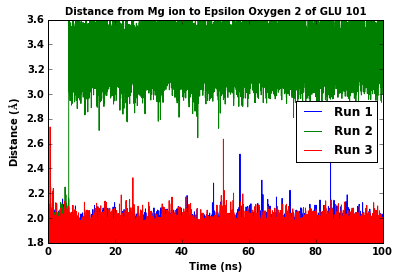

In [37]:

case
for i,case in enumerate(cases[0:1]):
 sel1 = loos.selectAtoms(case.system,'name == "MG" && resid == 109')
 sel2 = loos.selectAtoms(case.system,'name == "OE2" && resid == 101')
 for j, run in enumerate(runs):
   idx = np.int(run)-1 # since not zero-indexes    
   dists = pf.dodist(case,idx,sel1,sel2)
   print np.mean(dists[:,1])
   print np.std(dists[:,1])
   plot(dists[:,0],dists[:,1],label=("Run "+run) )
    #plot(dists[:,0],dists[:,1],label="%s/%s"%(case.name,run) ) 
font = {'weight' : 'bold','size'   : 10}
matplotlib.rc('font', **font)
    
plt.xlabel("Time (ns)", **font)
plt.ylabel("Distance ($\AA$)", **font) 
plt.title("Distance from Mg ion to Epsilon Oxygen 2 of GLU 101", **font)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc='best')
plt.ylim(1.8,3.6)
plt.gcf().savefig("GLU101_O2_MGDist.png", dpi=300)




#### Plot distance between C-alpha atoms of Y58 and G99 

In [5]:


#pf.PlotCalphaDist(cases,runs,50,85,title="FANCY GRAPH")
#pf.PlotCalphaDist(mynewlist,runs,50,85,title="CALPHA_TRAJECTORIES")


### Miscellaneous contacts from Parv paper

(49,50) to 85 distance is supposed to be preserved in apo, not holo (apo doesn't show it either)

Interface 'stabilizers':
P21/T78
D22/S30
T23,F24 /D81


In [5]:
#wtCase = cases[1]
#wtCase.col='b'
#L85FCase = cases[2]
#L85FCase.col='r'
#L85ACase = cases[4]
#L85ACase.col = 'y'
#cas1=[19,24]; title="Distance between Alpha Carbons of residue %d and %d" % (cas1[0],cas1[1])
#pf.PlotCalphaDist(mynewlist,runs,cas1[0],cas1[1],title=title,adjylim=True,ylim=[0,40])

#cas2=[20,23]; title="Distance between Alpha Carbons of residue %d and %d" % (cas2[0],cas2[1])
#pf.PlotCalphaDist(mynewlist,runs,cas2[0],cas2[1],title=title,adjylim=True,ylim=[0,30])

#cas3=[18,26]; title="Distance between Alpha Carbons of residue %d and %d" % (cas3[0],cas3[1])
#pf.PlotCalphaDist(mynewlist,runs,cas3[0],cas3[1],title=title,adjylim=True,ylim=[5,50])

#cas4=[24,81]; title="Distance between Alpha Carbons of residue %d and %d" % (cas4[0],cas4[1])
#pf.PlotCalphaDist(mynewlist,runs,cas4[0],cas4[1],title=title,adjylim=True,ylim=[5,35],xlim=[0,1500])

#cas5=[23,81]; title="Distance between Alpha Carbons of residue %d and %d" % (cas5[0],cas5[1])
#pf.PlotCalphaDist(mynewlist,runs,cas5[0],cas5[1],title=title,adjylim=True,ylim=[5,40],xlim=[0,1500])

#cas6=[22,30]; title="Distance between Alpha Carbons of residue %d and %d" % (cas6[0],cas6[1])
#pf.PlotCalphaDist(mynewlist,runs,cas6[0],cas6[1],title=title,adjylim=True,ylim=[10,40],xlim=[0,1500])

#cas7=[21,78]; title="Distance between Alpha Carbons of residue %d and %d" % (cas7[0],cas7[1])
#pf.PlotCalphaDist(mynewlist,runs,cas7[0],cas7[1],title=title,adjylim=True,ylim=[5,60],xlim=[0,1500])

cas8=[49,85]; title="Distance between Alpha Carbons of residue %d and %d" % (cas8[0],cas8[1])
pf.PlotCalphaDist(mynewlist,runs,cas8[0],cas8[1],title=title,adjylim=True,ylim=[5,30],xlim=[0,1500])

cas9=[50,85]; title="Distance between Alpha Carbons of residue %d and %d" % (cas9[0],cas9[1])
pf.PlotCalphaDist(mynewlist,runs,cas9[0],cas9[1],title=title,adjylim=True,ylim=[5,30], xlim=[0,1500])

NameError: name 'mynewlist' is not defined

### Helix plots
### numbering based on apo/holo resolved structures 


\begin{table}[h]
\begin{tabular}{llllll}
\hline
apo &     & holo &        & concensus &     \\ \hline
8   & 17  & 8    & 18     & 8         & 17  \\ \hline
25  & 37  & 26   & 33/~36 & 26        & 36? \\ \hline
39  & 48  & 40   & 50     & 40        & 48  \\ \hline
64  & 70  & 61   & 70     & 64        & 70  \\ \hline
80  & 87  & 79   & 89     & 80        & 87  \\ \hline
99  & 107 & 99   & 107    & 99        & 107 \\ \hline
\end{tabular}
\end{table}

From my MDs
<code>
A: 9-18
B 25-37
C 42-50 
D 60-68
E 78-89
F 91-108
</code>    

In [11]:
hA = [8,17]
hB = [26,36]
hC = [40,48]
hD = [64,70]
hE = [80,87]
hF = [99,107]

In [12]:

def seldist(dists,fr,sel1,sel2):
  c1 = sel1.centroid()
  c2 = sel2.centroid()
  diff = c1-c2
  distance = diff.length()
#  print "distance ",distance 
  dists[fr,1] = distance

def dodist(case,j,sel1,sel2,maxFrame=1e9):
    dists = np.zeros((case.trajs[j].nframes(),2))
    #print "shape: ", np.shape(dists)
    dists[:,0] = np.arange(case.trajs[j].nframes())*case.frame_to_time
    #print "dists", dists 
    # instantiate a new iterator 
    ptraj = PyTraj.PyTraj(case.trajs[j], case.system[j])
    
    fr=0
    for frame in ptraj:
      seldist(dists,fr,sel1,sel2)  
      #print "seldist", seldist
      #seldist(distschain2,fr,sel1chain2,sel2chain2)  
      fr+=1
      if fr>maxFrame:
            break
    print fr
#    print "I'm here!"
  #  print "dist shape:",len(dists) 
    return dists

def BarPlotMeans(cases,runs,title="",root="./"):
#    plt.figure()
    fig,ax = plt.subplots()
    width = 0.25
    means = []
    stds = []
    nsamples = []
    idxs = np.arange(len(cases))
    names = []
    barcolors = []
 #   for j, run in enumerate(runs):
    for i, case in enumerate(cases):
          means.append(case.means[i])
          stds.append(case.stds[i])
          nsamples.append(case.nsamples[i])
          names.append(case.name)
          barcolors.append(case.col)


        # std error
    stds = np.array(stds)
    nsamples = np.array(nsamples)
        #conf = 1.96 * stds/np.sqrt(nsamples)
        #barlist = ax.bar(idxs+j*width,means,yerr=conf,width=width)
        #print stds
    barlist = ax.bar(idxs+j*width,means,yerr=stds,width=width,ecolor='k')
    for i, case in enumerate(cases):
        barlist[i].set_color(barcolors[i])

    plt.title(title)
    ax.set_xticks(idxs+1.5*width)
    ax.set_xticklabels( names )


In [13]:
def PlotCalphaDist_atoms(cases,runs,res1,res2,\
                   adjylim=False, ylim=[0,0], adjxlim=False, xlim=[0,0],\
                   title="",root="/net/share/anku223/PV/"):
    ## compute dists
    ## plot trajectory
  metrics = []
  caseName = "unk"
  plt.figure()
  i=0; case = cases[i]
  
  for i,case in enumerate(cases):
      case.means = np.zeros(np.int(len(runs)))
      case.stds = np.zeros(np.int(len(runs)))
      case.nsamples = np.zeros(np.int(len(runs)))
      j=0; run=j+1
      for j, run in enumerate(runs):

        sel1 = loos.selectAtoms(case.system[j],'name == "CA" && resid == %d' % res1)
        sel2 = loos.selectAtoms(case.system[j],'name == "CA" && resid == %d' % res2)
     #   print "sel1", sel1
     #   print "sel2", sel2
        
    #        if 0:
        idx = np.int(run)-1 # since not zero-indexes    
        dists = dodist(case,j,sel1,sel2,maxFrame=50000)
        #print "dists: ", dists[:,1]
       # plt.xlim([0.4,0.5])
        plt.plot(dists[:,0],dists[:,1],case.col+cols[j],label="%s/%s"%(case.name,run))
     #   plt.plot(dists[:,0],dists[:,1])
        metric = dists[:,1]
#        print "metric: ", metric
        metrics.append(metric)
        
        plt.xlabel("time [ns]")

#        plt.legend(loc=0, ncol=2)
        if adjylim:
          plt.ylim(ylim)
        plt.title(title)

      case.means[i] = np.mean(metrics)
      case.stds[i] = np.std(metrics)
      case.nsamples[i] = np.shape(metrics)[0]

  BarPlotMeans(cases,runs,title=title,root=root) # "CalphaDist")

#### Will use as placeholder for helix A RMSD/order parameter 

In [14]:
PlotCalphaDist_atoms(cases,runs,hA[0],hA[1])
PlotCalphaDist_atoms(cases,runs,hB[0],hB[1])

TypeError: in method 'selectAtoms', argument 1 of type 'loos::AtomicGroup const &'

In [ ]:
skip = 100; stride = 30


pf.doHelixPlot(cases,runs,hA,"HA",skip=skip,stride=stride)
if 0:
  for i,case in enumerate(cases):
      case.hAcentroids = [None]*len(runs)
      for j, run in enumerate(runs):
          case.hAcentroids[j]=case.centroids[j]


HERE


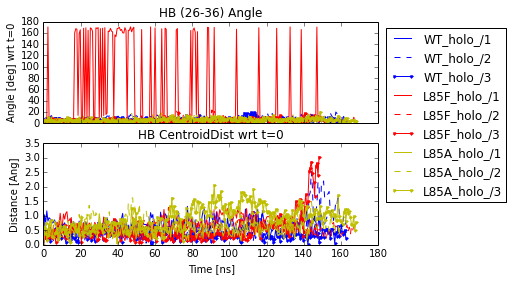

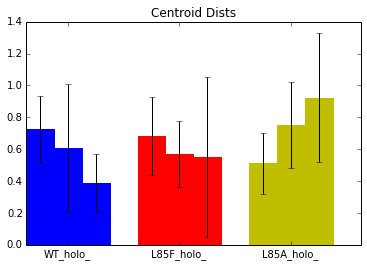

In [87]:
pf.doHelixPlot(cases,runs,hB,"HB",skip=skip,stride=stride)
for i,case in enumerate(cases):
      case.hBcentroids = [None]*len(runs)
      for j, run in enumerate(runs):
          case.hBcentroids[j]=case.centroids[j]


In [1]:
pf.doHelixPlot(cases,runs,hC,"HC",skip=skip,stride=stride)
for i,case in enumerate(cases):
      case.hCcentroids = [None]*len(runs)
      for j, run in enumerate(runs):
          case.hCcentroids[j]=case.centroids[j]

NameError: name 'pf' is not defined

HERE


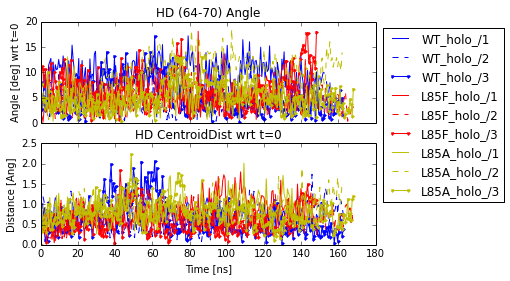

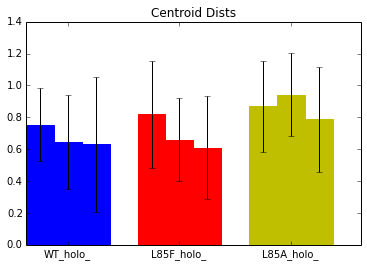

In [89]:
pf.doHelixPlot(cases,runs,hD,"HD",skip=skip,stride=stride)
for i,case in enumerate(cases):
      case.hDcentroids = [None]*len(runs)
      for j, run in enumerate(runs):
          case.hDcentroids[j]=case.centroids[j]


HERE


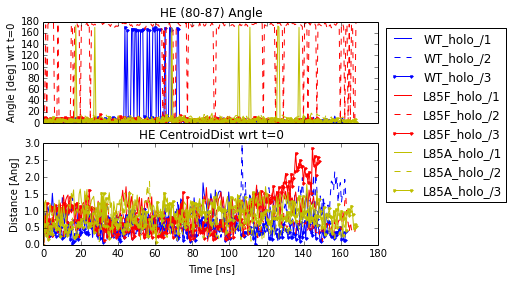

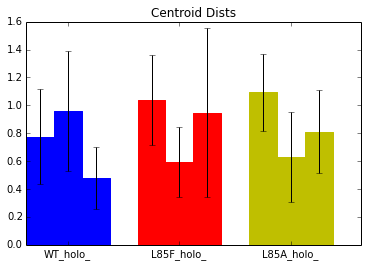

In [90]:
pf.doHelixPlot(cases,runs,hE,"HE",skip=skip,stride=stride)
for i,case in enumerate(cases):
      case.hEcentroids = [None]*len(runs)
      for j, run in enumerate(runs):
          case.hEcentroids[j]=case.centroids[j]


HERE


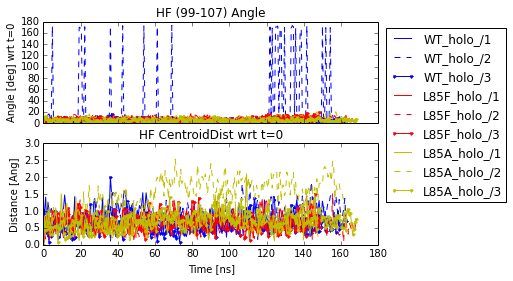

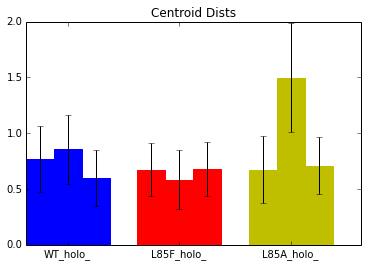

In [91]:
pf.doHelixPlot(cases,runs,hF,"HF",skip=skip,stride=stride)
for i,case in enumerate(cases):
      case.hFcentroids = [None]*len(runs)
      for j, run in enumerate(runs):
          case.hFcentroids[j]=case.centroids[j]


### Packing 

In [27]:

pf.CalcInterhelicalDist(cases,runs,"HA","HD",skip=skip,stride=stride)
pf.CalcInterhelicalDist(cases,runs,"HC","HD",skip=skip,stride=stride)
pf.CalcInterhelicalDist(cases,runs,"HE","HF",skip=skip,stride=stride)
    
        

NameError: name 'skip' is not defined

## Distance between L85 and centroids of other helices

7741
8250
7500
8515
7741
8250
7500
8515
7741
8250
7500
8515
7741
8250
7500
8515
7741
8250
7500
8515


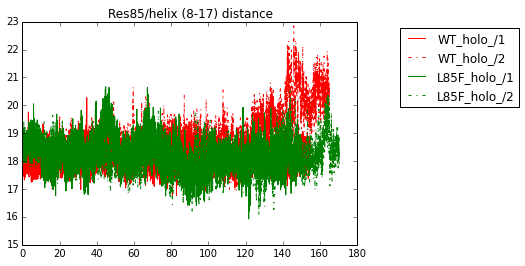

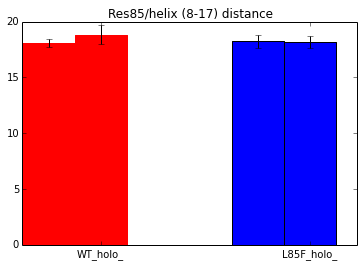

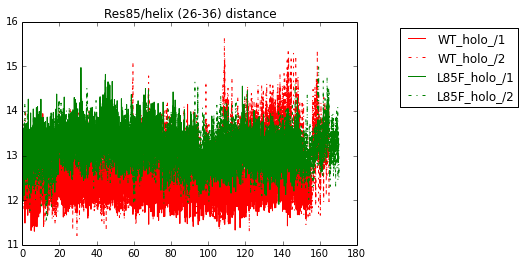

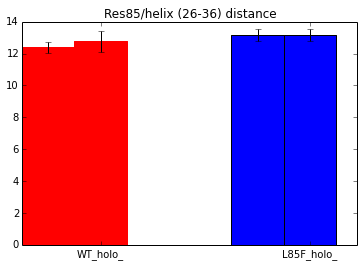

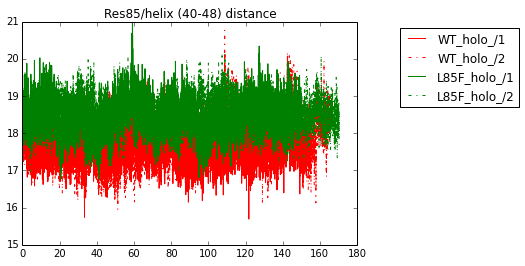

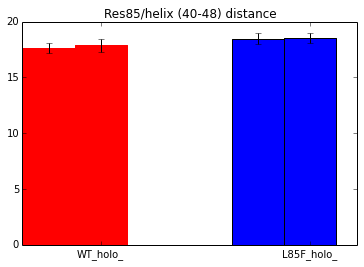

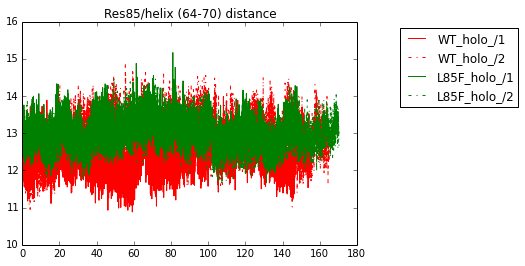

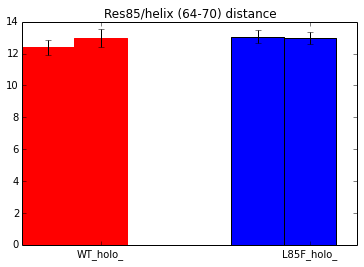

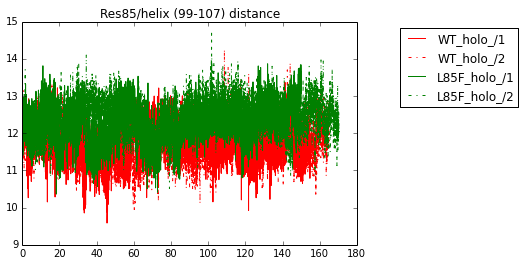

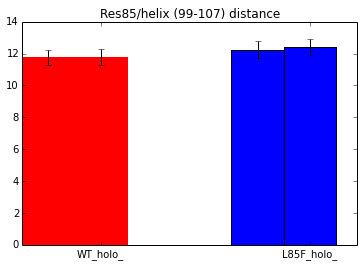

In [17]:
pf.cols = cols
holos[0].col = 'r' # WT_holo
holos[1].col = 'g' # L85F_holo


pf.ResHelixDist(holos,runs,85,hA)
pf.ResHelixDist(holos,runs,85,hB)
pf.ResHelixDist(holos,runs,85,hC)
pf.ResHelixDist(holos,runs,85,hD)
pf.ResHelixDist(holos,runs,85,hF)


# <font color="red">Under construction (rely on ptraj)</font>

### Step 3. Dynamic cross correlation matrix with ptraj
This matrix shows collective motion between residues. Highly correlated residues have correlation values of 1. (red), while uncorrelated have values approaching 0 (blue)

To generate the files needed, I ran the following (but you need not)
<ul>
<li> Compute cross-correlation matrix using ptraj (also rmsf in the same dccm.in file)
<code>
source ~/bin/amber.bash 
PRM=/u1/shared/parvanalysisAmber/WT_holo_1.pdb
$AMBERHOME/bin/ptraj $PRM  < dccm.in > dccm.out
</code>
    
<li> This command will generate <code>matrix_correl_CA.dat</code>
    
    </ul>    

#### Define function 

In [ ]:
def plotcorr(dccmName,title="",figName="corr.png"):
  v=np.loadtxt(dccmName)
  plt.figure(figsize=(8,8))
  #pcolormesh(np.arange(109),np.arange(109),v,cmap="RdBu_r")
  pcolormesh(v,cmap="RdBu_r")
  plt.colorbar()
  plt.xlim([0,109])
  plt.ylim([0,109])
  plt.clim([-1,1])
  plt.title(title)  
  plt.xlabel("resid")
  axes().set_aspect('equal')
  plt.gcf().savefig(figName)  
  return v  

In [ ]:
name = "_correl_CA.dat"
#apoName="/net/home/huskeypm/localTemp/parv/amber_apo/"+name
caseName=prefix+case+name
#apo=plotcorr(apoName,title="apo")
holo=plotcorr(caseName,title=case,figName=case+"_corr.png")

Sites I and II (where Ca2+ bind) are located approximately at 52-63 and 92-99. The pairing of Y58-G99 marks the beta sheet formed between sites I and II .

### Step 4. RMSF with ptraj
Atomic fluctuations RMSF also computed using ptraj/dccm.in sscript

In [ ]:
def plotrmsf(rmsfName,title="",plot=True,figName="rmsfCa.png"):
  v=np.loadtxt(rmsfName)
  if(plot==False):
        return v
  plt.figure(figsize=(8,8))
  #pcolormesh(np.arange(109),np.arange(109),v,cmap="RdBu_r")
  plt.plot(v[:,0],v[:,1])
  plt.title(title)  
  plt.xlabel("resid")
  #axes().set_aspect('equal')
  plt.gcf().savefig(figName)  
  return v  

In [ ]:
name = "_rmsf_CA.dat"
#apoName="/net/home/huskeypm/localTemp/parv/amber_apo/"+name
caseName=prefix+case+name
#apo=plotrmsf(apoName,title="apo",plot=False)
holo=plotrmsf(caseName,title=case,figName=case+"_rmsfCa.png")

## Comparison between cases


In [ ]:
wt_apoCase= "WT_apo_1"
wt_holoCase= "WT_holo_1"
wt_apo=plotrmsf(prefix+wt_apoCase+name,plot=False)
wt_holo=plotrmsf(prefix+wt_holoCase+name,plot=False)

plot(wt_apo[:,0],wt_apo[:,1],'r',label=wt_apoCase)
plot(wt_holo[:,0],wt_holo[:,1],'b',label=wt_holoCase)
plt.title(wt_apoCase + " vs " + wt_holoCase)
plt.legend(loc=0)

In [ ]:
L85A_apoCase= "L85A_apo_1"
L85A_holoCase= "L85A_holo_1"
L85A_apo=plotrmsf(prefix+L85A_apoCase+name,plot=False)
L85A_holo=plotrmsf(prefix+L85A_holoCase+name,plot=False)

plot(L85A_apo[:,0],L85A_apo[:,1],'r',label=L85A_apoCase)
plot(L85A_holo[:,0],L85A_holo[:,1],'b',label=L85A_holoCase)
plt.title(L85A_apoCase + " vs " + L85A_holoCase)
plt.legend(loc=0)

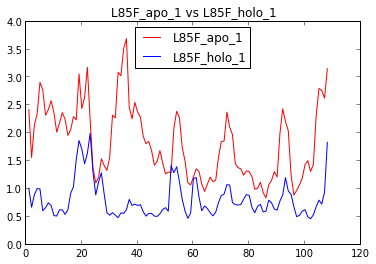

In [115]:
L85F_apoCase= "L85F_apo_1"
L85F_holoCase= "L85F_holo_1"
L85F_apo=plotrmsf(prefix+L85F_apoCase+name,plot=False)
L85F_holo=plotrmsf(prefix+L85F_holoCase+name,plot=False)

plot(L85F_apo[:,0],L85F_apo[:,1],'r',label=L85F_apoCase)
plot(L85F_holo[:,0],L85F_holo[:,1],'b',label=L85F_holoCase)
plt.title(L85F_apoCase + " vs " + L85F_holoCase)
plt.legend(loc=0)

In [21]:
plot(wt_apo[:,0],wt_apo[:,1],'r',label=wt_apoCase)
plot(L85A_apo[:,0],L85A_apo[:,1],'g',label=L85A_apoCase)
plot(L85F_apo[:,0],L85F_apo[:,1],'b',label=L85F_apoCase)


plt.title("apo cases")
plt.legend(loc=0)

NameError: name 'wt_apo' is not defined

In [22]:
plot(wt_holo[:,0],wt_holo[:,1],'r',label=wt_holoCase)
plot(L85A_holo[:,0],L85A_holo[:,1],'g',label=L85A_holoCase)
plot(L85F_holo[:,0],L85F_holo[:,1],'b',label=L85F_holoCase)


plt.title("holo cases")
plt.legend(loc=0)

NameError: name 'wt_holo' is not defined

In [11]:
sel1 = loos.selectAtoms(case.system,'name == "MG" && resid == 110')
sel2 = loos.selectAtoms(case.system,'name == "OD1" && resid == 51')
for j, run in enumerate(runs):
   idx = np.int(run)-1 # since not zero-indexes    
   dists = pf.dodist(case,idx,sel1,sel2)
   print np.mean(dists[:,1])
   print np.std(dists[:,1])

50000
1.84373959831
0.05035537037
50000
1.84908336482
0.0513055729928
50000
1.800808871
0.0407184359819


In [12]:
sel1 = loos.selectAtoms(case.system,'name == "MG" && resid == 110')
sel2 = loos.selectAtoms(case.system,'name == "OD1" && resid == 53')
for j, run in enumerate(runs):
   idx = np.int(run)-1 # since not zero-indexes    
   dists = pf.dodist(case,idx,sel1,sel2)
   print np.mean(dists[:,1])
   print np.std(dists[:,1])

50000
1.81851434976
0.043690248361
50000
1.81692766346
0.0435551463766
50000
1.8174867137
0.0437782735384


In [13]:
sel1 = loos.selectAtoms(case.system,'name == "MG" && resid == 110')
sel2 = loos.selectAtoms(case.system,'name == "O" && resid == 55')
for j, run in enumerate(runs):
   idx = np.int(run)-1 # since not zero-indexes    
   dists = pf.dodist(case,idx,sel1,sel2)
   print np.mean(dists[:,1])
   print np.std(dists[:,1])

50000
4.40477605486
0.850714315224
50000
7.96967670513
0.299344088433
50000
6.60078818497
0.422298849361


In [14]:
sel1 = loos.selectAtoms(case.system,'name == "MG" && resid == 110')
sel2 = loos.selectAtoms(case.system,'name == "O" && resid == 57')
for j, run in enumerate(runs):
   idx = np.int(run)-1 # since not zero-indexes    
   dists = pf.dodist(case,idx,sel1,sel2)
   print np.mean(dists[:,1])
   print np.std(dists[:,1])

50000
4.26743312784
0.28414132629
50000
3.84399634833
0.242441407369
50000
2.22360588207
0.174312150181


In [15]:
sel1 = loos.selectAtoms(case.system,'name == "MG" && resid == 110')
sel2 = loos.selectAtoms(case.system,'name == "OD2" && resid == 59')
for j, run in enumerate(runs):
   idx = np.int(run)-1 # since not zero-indexes    
   dists = pf.dodist(case,idx,sel1,sel2)
   print np.mean(dists[:,1])
   print np.std(dists[:,1])

50000
5.43739860095
1.16739997352
50000
5.62220883677
1.20716905108
50000
5.80071987156
1.37322122634


In [16]:
sel1 = loos.selectAtoms(case.system,'name == "MG" && resid == 110')
sel2 = loos.selectAtoms(case.system,'name == "OE1" && resid == 62')
for j, run in enumerate(runs):
   idx = np.int(run)-1 # since not zero-indexes    
   dists = pf.dodist(case,idx,sel1,sel2)
   print np.mean(dists[:,1])
   print np.std(dists[:,1])
    
sel1 = loos.selectAtoms(case.system,'name == "MG" && resid == 110')
sel2 = loos.selectAtoms(case.system,'name == "OE2" && resid == 62')
for j, run in enumerate(runs):
   idx = np.int(run)-1 # since not zero-indexes    
   dists = pf.dodist(case,idx,sel1,sel2)
   print np.mean(dists[:,1])
   print np.std(dists[:,1])

50000
1.8969140958
0.0658893542754
50000
1.88564606946
0.0612287571085
50000
1.86493321921
0.0564333024275
50000
1.89626452148
0.0663086307733
50000
1.89484563285
0.0637551020929
50000
1.88348934459
0.0626548096873
